## Market trades, summary statistics

THis is a rough summary of market trades data.

In [1]:
from aspidoceleon.bigquery import BigQuery
from aspidoceleon.dataframe import convert_timestamp_columns
from charadrius.const import Const
from loguru import logger
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import re
import os
import glob
constants = Const()
bigquery = BigQuery()

# workdir
workdir = f"{constants.PROJECT_WORKDIR}/market_trades"
os.makedirs(workdir, exist_ok=True)
logger.info("workdir")

# This week, Sunday to today inclusive
TODAY = datetime.datetime.now().strftime(constants.DATE_FMT_NODASH)
WEEK_START = pd.to_datetime(datetime.datetime.now()).to_period("W-SAT").start_time.strftime(constants.DATE_FMT_NODASH)
logger.info(f"Date range: {WEEK_START}, {TODAY}")

2024-06-25 21:07:32.499 | INFO     | __main__:<module>:17 - workdir
2024-06-25 21:07:32.501 | INFO     | __main__:<module>:22 - Date range: 20240623, 20240625


### Read in real-time data

In [2]:
"""
Fetch market trades RT data
"""
fp_rt = f"{workdir}/market_trades_{WEEK_START}_{TODAY}.parquet"
# could skip caching by removing file
sql_rt = f"""
select
    *
from `fastitocalon.coinbase.rt_coinbase_market_trades_*`
where _table_suffix between '{WEEK_START}' and '{TODAY}'
"""
df_rt = bigquery.query_cache(sql=sql_rt, fp=fp_rt)
df_rt = convert_timestamp_columns(df_rt)
logger.info(f"fetched shape {df_rt.shape}")

2024-06-25 21:07:32.511 | INFO     | aspidoceleon.bigquery:query_cache:135 - reading <- /mnt/vol1/charadrius/market_trades/market_trades_20240623_20240625.parquet
2024-06-25 21:07:38.462 | INFO     | __main__:<module>:14 - fetched shape (1415496, 8)


In [3]:
"""
quick summary
"""
print(df_rt.shape)
print(df_rt['local_timestamp'].agg(['min','max']))
print(df_rt.dtypes)
df_rt.head()

(1415496, 8)
min   2024-06-23 00:00:17.646824+00:00
max   2024-06-25 20:16:15.853874+00:00
Name: local_timestamp, dtype: datetime64[ns, UTC]
symbol                          object
timestamp          datetime64[ns, UTC]
local_timestamp    datetime64[ns, UTC]
is_snapshot                    boolean
id                               Int64
side                            object
price                          float64
amount                         float64
dtype: object


,symbol,timestamp,local_timestamp,is_snapshot,id,side,price,amount
0,ethusd,2024-06-25 11:00:51.589736+00:00,2024-06-25 11:01:08.079784+00:00,True,533000559,sell,3376.81,0.998352
1,ethusd,2024-06-25 11:00:51.503889+00:00,2024-06-25 11:01:08.079784+00:00,True,533000558,buy,3376.80,1.444762
2,ethusd,2024-06-25 11:00:51.503889+00:00,2024-06-25 11:01:08.079784+00:00,True,533000557,buy,3376.80,0.000314
3,ethusd,2024-06-25 11:00:57.061930+00:00,2024-06-25 11:01:08.079784+00:00,True,533000583,buy,3376.30,2.169860
4,ethusd,2024-06-25 11:00:44.405238+00:00,2024-06-25 11:01:08.079784+00:00,True,533000545,buy,3377.38,0.049002


### Read in batch data

In [4]:
"""
Read in batch data for given time period (all currencies)

Convert to same format as live data:
> remove exchange (redundant)
> convert symbols: lower, remove dash

and noting that the batch files are not snapshots, but the realtime data is (stream is too fast)
"""
df_batch = pd.concat([
    pd.read_parquet(f) for f in glob.glob("/mnt/vol1/coinbase_trades*")
    if (
        (pd.to_datetime(re.findall(r"2[0-9]+", f)[0]) >= pd.to_datetime(WEEK_START)) &
        (pd.to_datetime(re.findall(r"2[0-9]+", f)[0]) <= pd.to_datetime(TODAY))
    )
]).drop(columns=['exchange','date']) # redundant
for timestamp_col in ['timestamp','local_timestamp']:
    df_batch[timestamp_col] = df_batch[timestamp_col].astype("datetime64[ns, UTC]")
df_batch['id'] = df_batch['id'].astype("Int64")
df_batch['is_snapshot'] = False # no snapshots, actually all real data
df_batch['is_snapshot'] = df_batch['is_snapshot'].astype("boolean")
df_batch['symbol'] = df_batch['symbol'].apply(lambda x: x.replace("-","").lower())
df_batch = df_batch[df_rt.columns]

In [5]:
"""
quick summary
"""
print(df_batch.shape)
print(df_batch['local_timestamp'].agg(['min','max']))
print(df_batch.dtypes)
df_batch.head()

(1776761, 8)
min   2024-06-23 00:00:00.207433+00:00
max   2024-06-24 23:59:59.552363+00:00
Name: local_timestamp, dtype: datetime64[ns, UTC]
symbol                          object
timestamp          datetime64[ns, UTC]
local_timestamp    datetime64[ns, UTC]
is_snapshot                    boolean
id                               Int64
side                            object
price                          float64
amount                         float64
dtype: object


,symbol,timestamp,local_timestamp,is_snapshot,id,side,price,amount
0,solusd,2024-06-24 00:00:00.381756+00:00,2024-06-24 00:00:00.422670+00:00,False,128653915,buy,128.58,1.889748
1,solusd,2024-06-24 00:00:00.816921+00:00,2024-06-24 00:00:00.857808+00:00,False,128653916,sell,128.56,0.132789
2,solusd,2024-06-24 00:00:03.646877+00:00,2024-06-24 00:00:03.687965+00:00,False,128653917,buy,128.56,0.620463
3,solusd,2024-06-24 00:00:03.646877+00:00,2024-06-24 00:00:03.687984+00:00,False,128653918,buy,128.57,0.149485
4,solusd,2024-06-24 00:00:05.243297+00:00,2024-06-24 00:00:05.284410+00:00,False,128653919,buy,128.57,0.016752


### Check equalities and indices

In [6]:
assert (df_rt.columns == df_batch.columns).all()
assert (df_rt.dtypes == df_batch.dtypes).all()

### Compare time series

#### BTC

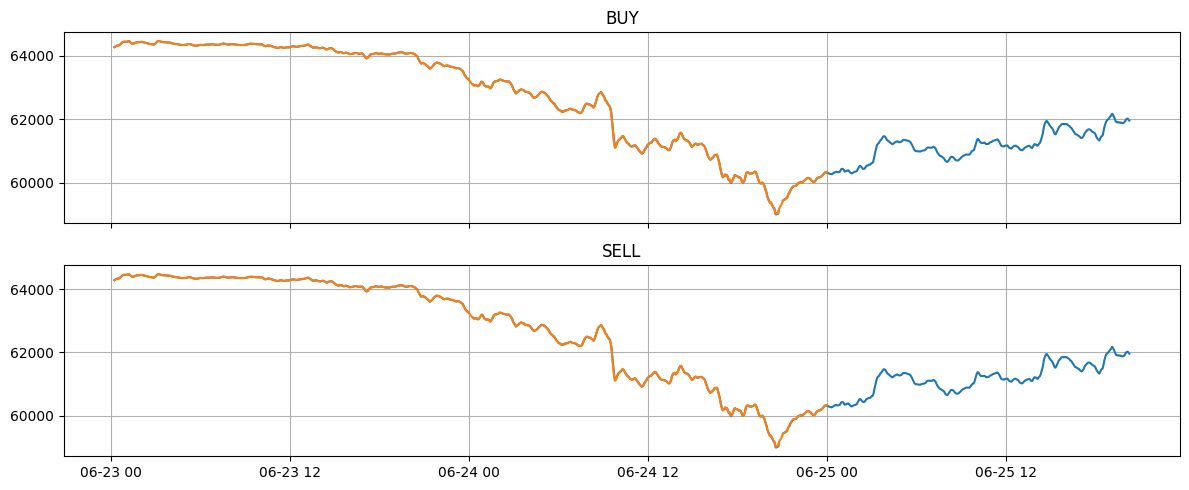

In [7]:
df_rt_agg = (
    # - snapshot, so take average (within time)
    # - truncate local timestamp to minute
    # - pivot
    df_rt
    .query("symbol == 'btcusd'").drop(columns=['symbol'])
    .assign(minute=lambda df: df['timestamp'].dt.floor(freq="min"))
    .groupby(['minute','side'])[['price']].mean()
    .reset_index()
    .assign(dataset="RT")
)

df_batch_agg = (
    # - snapshot, so take average (within time)
    # - truncate local timestamp to minute
    # - pivot
    df_batch
    .query("symbol == 'btcusd'").drop(columns=['symbol'])
    .assign(minute=lambda df: df['timestamp'].dt.floor(freq="min"))
    .groupby(['minute','side'])[['price']].mean()
    .reset_index()
    .assign(dataset="BATCH")
)

df_agg = pd.concat([df_rt_agg, df_batch_agg]).pivot(index=['minute'], columns=['dataset','side'])
df_agg = df_agg.rolling(15).mean() # rolling N-minute mean

f, ax = plt.subplots(figsize=(12,5), nrows=2, sharex=True)
plt.axes(ax[0])
plt.plot(df_agg.index, df_agg[[('price','RT','buy'),('price','BATCH','buy')]])
plt.title("BUY")
plt.grid(True)
plt.axes(ax[1])
plt.plot(df_agg.index, df_agg[[('price','RT','sell'),('price','BATCH','sell')]])
plt.title("SELL")
plt.grid(True)
plt.tight_layout()

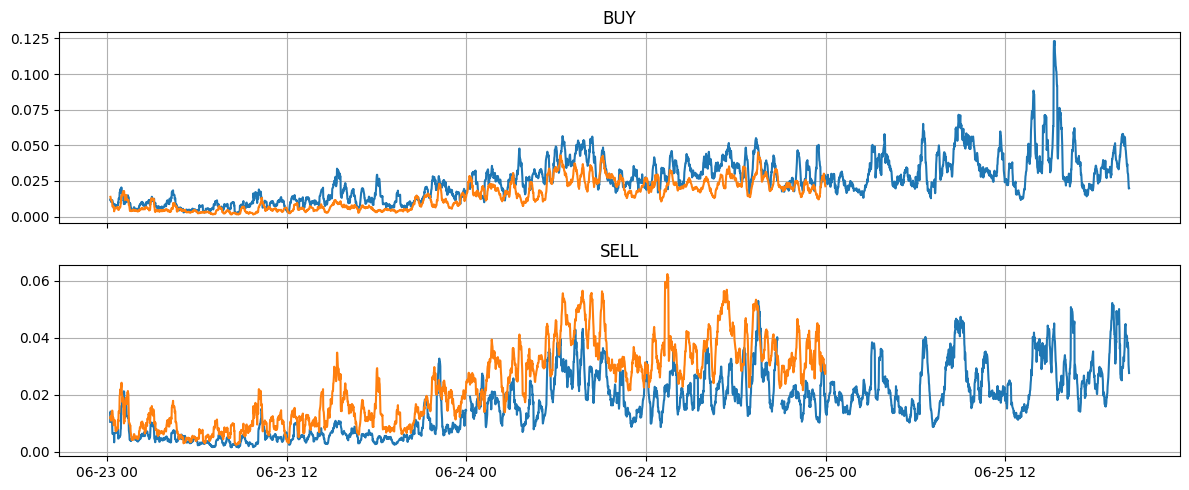

In [8]:
df_rt_agg = (
    # - snapshot, so take average (within time)
    # - truncate local timestamp to minute
    # - pivot
    df_rt
    .query("symbol == 'btcusd'").drop(columns=['symbol'])
    .assign(minute=lambda df: df['timestamp'].dt.floor(freq="min"))
    .groupby(['minute','side'])[['amount']].mean()
    .reset_index()
    .assign(dataset="RT")
)

df_batch_agg = (
    # - snapshot, so take average (within time)
    # - truncate local timestamp to minute
    # - pivot
    df_batch
    .query("symbol == 'btcusd'").drop(columns=['symbol'])
    .assign(minute=lambda df: df['timestamp'].dt.floor(freq="min"))
    # average amount
    .groupby(['minute','side'])[['amount']].mean()
    .reset_index()
    .assign(dataset="BATCH")
)

df_agg = pd.concat([df_rt_agg, df_batch_agg]).pivot(index=['minute'], columns=['dataset','side'])
df_agg = df_agg.rolling(15).mean() # rolling N-minute mean

f, ax = plt.subplots(figsize=(12,5), nrows=2, sharex=True)
plt.axes(ax[0])
plt.plot(df_agg.index, df_agg[[('amount','RT','buy'),('amount','BATCH','buy')]])
plt.title("BUY")
plt.grid(True)
plt.axes(ax[1])
plt.plot(df_agg.index, df_agg[[('amount','RT','sell'),('amount','BATCH','sell')]])
plt.title("SELL")
plt.grid(True)
plt.tight_layout()

In [9]:
# prices look good!
# amounts are much messier, although still follow the same trajectory
# remember that real-time market trades is sampled (snapshot every minute), while my data is the "golden source" known only at 1-day lag
# realistically I don't have enough $$$ to spend on huge computational power to ingest real-time perfectly
# so will need some kind of batch->realtime calibration model, if I do intraday.
# daily trading will be okay with only batch though.
# ((df_agg[('amount','RT','buy')] / df_agg[('amount','BATCH','buy')] - 1)).dropna().plot()

### ETH

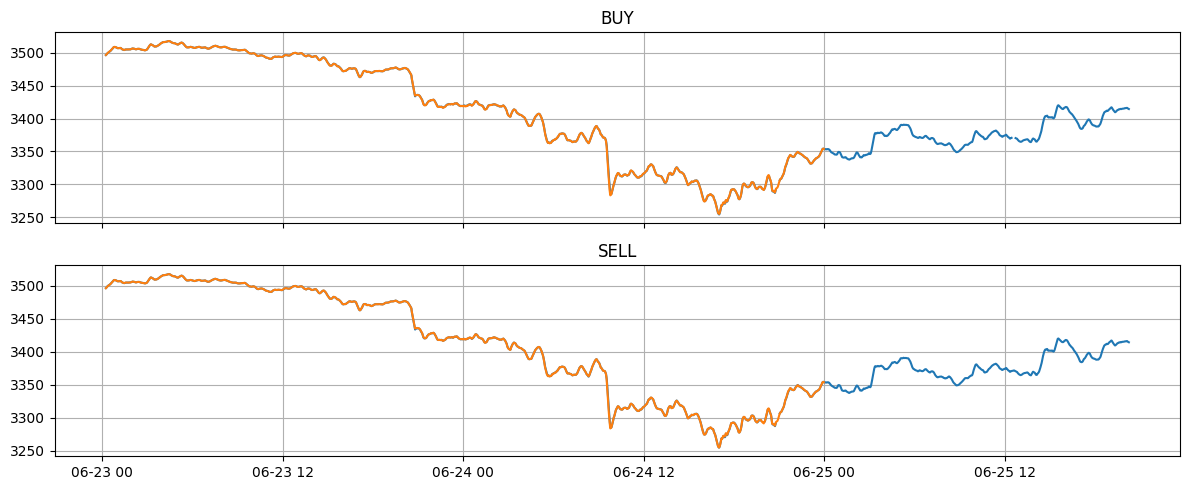

In [10]:
df_rt_agg = (
    # - snapshot, so take average (within time)
    # - truncate local timestamp to minute
    # - pivot
    df_rt
    .query("symbol == 'ethusd'").drop(columns=['symbol'])
    .assign(minute=lambda df: df['timestamp'].dt.floor(freq="min"))
    .groupby(['minute','side'])[['price']].mean()
    .reset_index()
    .assign(dataset="RT")
)

df_batch_agg = (
    # - snapshot, so take average (within time)
    # - truncate local timestamp to minute
    # - pivot
    df_batch
    .query("symbol == 'ethusd'").drop(columns=['symbol'])
    .assign(minute=lambda df: df['timestamp'].dt.floor(freq="min"))
    .groupby(['minute','side'])[['price']].mean()
    .reset_index()
    .assign(dataset="BATCH")
)

df_agg = pd.concat([df_rt_agg, df_batch_agg]).pivot(index=['minute'], columns=['dataset','side'])
df_agg = df_agg.rolling(15).mean() # rolling N-minute mean

f, ax = plt.subplots(figsize=(12,5), nrows=2, sharex=True)
plt.axes(ax[0])
plt.plot(df_agg.index, df_agg[[('price','RT','buy'),('price','BATCH','buy')]])
plt.title("BUY")
plt.grid(True)
plt.axes(ax[1])
plt.plot(df_agg.index, df_agg[[('price','RT','sell'),('price','BATCH','sell')]])
plt.title("SELL")
plt.grid(True)
plt.tight_layout()

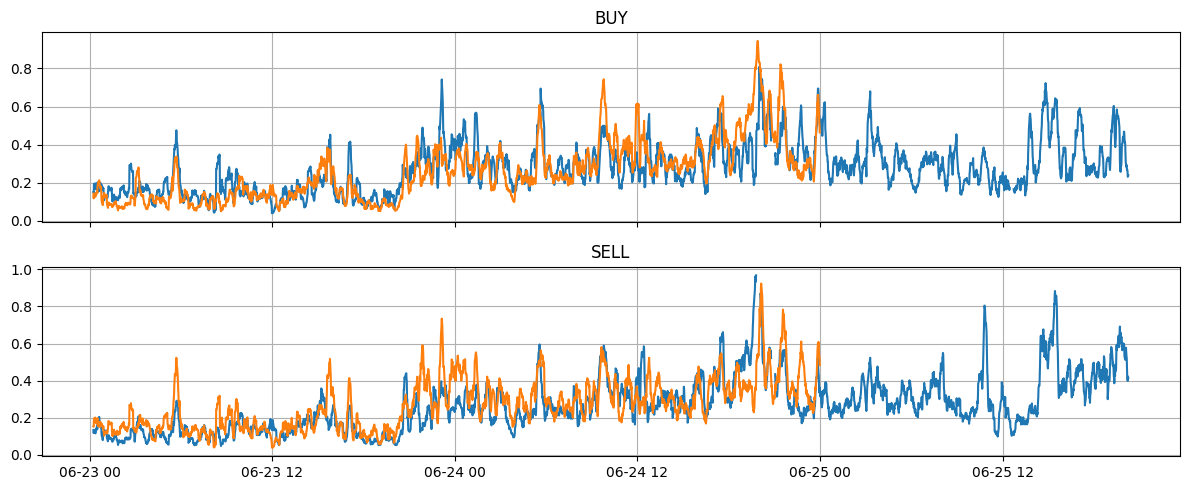

In [11]:
df_rt_agg = (
    # - snapshot, so take average (within time)
    # - truncate local timestamp to minute
    # - pivot
    df_rt
    .query("symbol == 'ethusd'").drop(columns=['symbol'])
    .assign(minute=lambda df: df['timestamp'].dt.floor(freq="min"))
    .groupby(['minute','side'])[['amount']].mean()
    .reset_index()
    .assign(dataset="RT")
)

df_batch_agg = (
    # - snapshot, so take average (within time)
    # - truncate local timestamp to minute
    # - pivot
    df_batch
    .query("symbol == 'ethusd'").drop(columns=['symbol'])
    .assign(minute=lambda df: df['timestamp'].dt.floor(freq="min"))
    .groupby(['minute','side'])[['amount']].mean()
    .reset_index()
    .assign(dataset="BATCH")
)

df_agg = pd.concat([df_rt_agg, df_batch_agg]).pivot(index=['minute'], columns=['dataset','side'])
df_agg = df_agg.rolling(15).mean() # rolling N-minute mean

f, ax = plt.subplots(figsize=(12,5), nrows=2, sharex=True)
plt.axes(ax[0])
plt.plot(df_agg.index, df_agg[[('amount','RT','buy'),('amount','BATCH','buy')]])
plt.title("BUY")
plt.grid(True)
plt.axes(ax[1])
plt.plot(df_agg.index, df_agg[[('amount','RT','sell'),('amount','BATCH','sell')]])
plt.title("SELL")
plt.grid(True)
plt.tight_layout()

### SOL

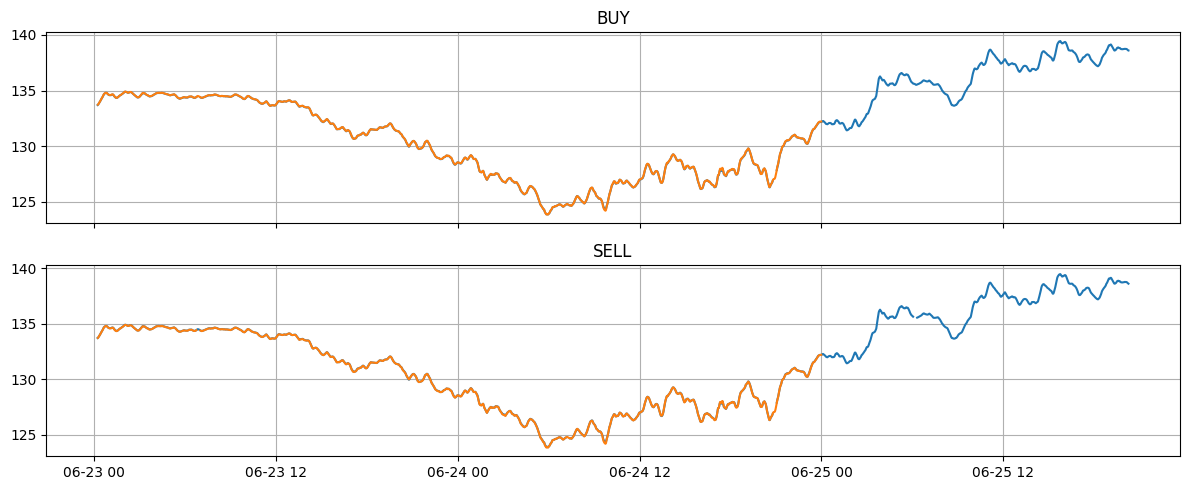

In [12]:
df_rt_agg = (
    # - snapshot, so take average (within time)
    # - truncate local timestamp to minute
    # - pivot
    df_rt
    .query("symbol == 'solusd'").drop(columns=['symbol'])
    .assign(minute=lambda df: df['timestamp'].dt.floor(freq="min"))
    .groupby(['minute','side'])[['price']].mean()
    .reset_index()
    .assign(dataset="RT")
)

df_batch_agg = (
    # - snapshot, so take average (within time)
    # - truncate local timestamp to minute
    # - pivot
    df_batch
    .query("symbol == 'solusd'").drop(columns=['symbol'])
    .assign(minute=lambda df: df['timestamp'].dt.floor(freq="min"))
    .groupby(['minute','side'])[['price']].mean()
    .reset_index()
    .assign(dataset="BATCH")
)

df_agg = pd.concat([df_rt_agg, df_batch_agg]).pivot(index=['minute'], columns=['dataset','side'])
df_agg = df_agg.rolling(15).mean() # rolling N-minute mean

f, ax = plt.subplots(figsize=(12,5), nrows=2, sharex=True)
plt.axes(ax[0])
plt.plot(df_agg.index, df_agg[[('price','RT','buy'),('price','BATCH','buy')]])
plt.title("BUY")
plt.grid(True)
plt.axes(ax[1])
plt.plot(df_agg.index, df_agg[[('price','RT','sell'),('price','BATCH','sell')]])
plt.title("SELL")
plt.grid(True)
plt.tight_layout()

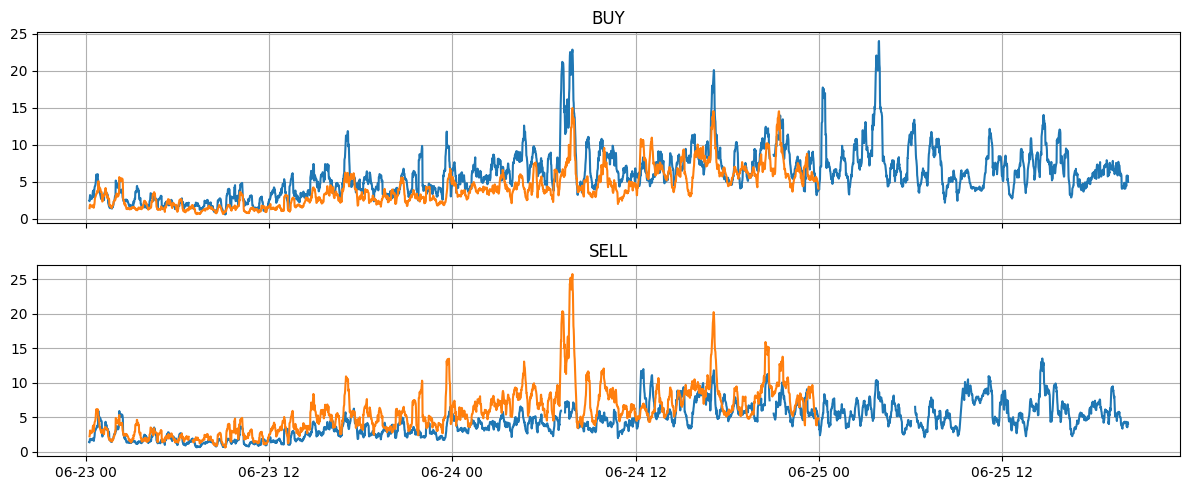

In [13]:

df_rt_agg = (
    # - snapshot, so take average (within time)
    # - truncate local timestamp to minute
    # - pivot
    df_rt
    .query("symbol == 'solusd'").drop(columns=['symbol'])
    .assign(minute=lambda df: df['timestamp'].dt.floor(freq="min"))
    .groupby(['minute','side'])[['amount']].mean()
    .reset_index()
    .assign(dataset="RT")
)

df_batch_agg = (
    # - snapshot, so take average (within time)
    # - truncate local timestamp to minute
    # - pivot
    df_batch
    .query("symbol == 'solusd'").drop(columns=['symbol'])
    .assign(minute=lambda df: df['timestamp'].dt.floor(freq="min"))
    .groupby(['minute','side'])[['amount']].mean()
    .reset_index()
    .assign(dataset="BATCH")
)

df_agg = pd.concat([df_rt_agg, df_batch_agg]).pivot(index=['minute'], columns=['dataset','side'])
df_agg = df_agg.rolling(15).mean() # rolling N-minute mean

f, ax = plt.subplots(figsize=(12,5), nrows=2, sharex=True)
plt.axes(ax[0])
plt.plot(df_agg.index, df_agg[[('amount','RT','buy'),('amount','BATCH','buy')]])
plt.title("BUY")
plt.grid(True)
plt.axes(ax[1])
plt.plot(df_agg.index, df_agg[[('amount','RT','sell'),('amount','BATCH','sell')]])
plt.title("SELL")
plt.grid(True)
plt.tight_layout()